# Прогноз проницаемости образцов горной породы по петрофизическим свойствам методами машинного обучения

Необходимо разработать методику для прогноза проницаемости образцов горной породы по их петрофизическим свойствам методами машинного обучения.
Входными признаками являются: 
<ol>
<li>Общая пористость образца ($\Phi$) - это доля объёма порового пространства в общем объёме горного образца.
<li>Профиль пористости образца вдоль оси Z ($\phi_z$) - локальная пористость горного образца замеренная вдоль оси Z, она показывает степень однородности породы по направлению оси Z.
</ol>

Целевая функция:

Абсолютная проницаемость вдоль оси Z ($k_z$)- это величина, характеризующая способность горного образца пропускать жидкость (или газ) при перепаде давления, типичная размерность мД (миллидарси). Чем это значение выше, тем лучше образец пропускает жидкость.

## Загрузка обучающей выборки и визуализация данных

Сначала загрузим необходимые python библиотеки и базу данных обучающей выборки.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Загрузка общей пористости образцов ($\Phi$, porosity):

In [2]:
porosity=np.genfromtxt('porosity.csv',invalid_raise=False,comments='#',delimiter=',')
print('Количество образцов в обучающей выборке: ',np.size(porosity))

Количество образцов в обучающей выборке:  100


Загрузка профиля пористости образца вдоль оси Z ($\phi_z$, porosityProfile):

In [3]:
porosityProfile=np.genfromtxt('porosityProfile.csv',invalid_raise=False,comments='#',delimiter=',')

Профиль пористости был замерен с интервалом 5 мкм.

Загрузка абсолютной проницаемости вдоль оси Z ($k_z$, permeabilityZ):

In [4]:
permeabilityZ=np.genfromtxt('permeabilityZ.csv',invalid_raise=False,comments='#',delimiter=',')

Теперь, визуализируем загруженные данные.

График проницаемость - пористость ($k_z$ - $\Phi$) с полулогарифмическим масштабом:

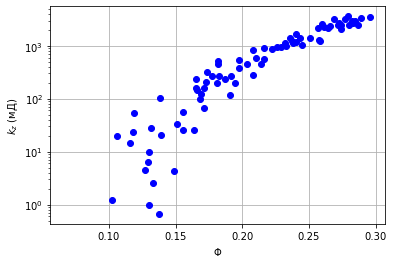

In [5]:
#plt.plot(porosity,permeabilityZ,'ob')
plt.semilogy(porosity,permeabilityZ,'ob')
plt.grid()
plt.xlabel('$\Phi$')
plt.ylabel('$k_z$ (мД)')
plt.show()

График профиля пористости вдоль оси Z (интервал замеров 5 мкм) для первого образца:

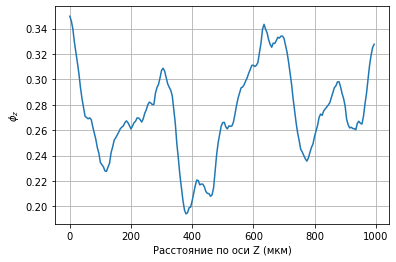

In [6]:
Z = np.arange(len(porosityProfile[0,:])) * 5 # (мкм)
plt.plot(Z,porosityProfile[0,:])
plt.grid()
plt.xlabel('Расстояние по оси Z (мкм)')
plt.ylabel('$\phi_z$')
plt.show()

Профиль пористости вдоль оси Z (интервал замеров 5 мкм) для всех образцов на одном графике:

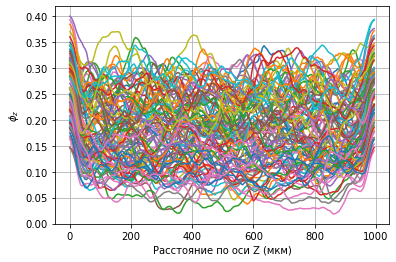

In [7]:
for i in np.arange(len(porosityProfile[:,0])):
    plt.plot(Z,porosityProfile[i,:])
plt.grid()
plt.xlabel('Расстояние по оси Z (мкм)')
plt.ylabel('$\phi_z$')
plt.show()

## Простейшая зависимость проницаемости от общей пористости

График $k_z$ - $\Phi$ показывает, что в первом приближении можно построить зависимость проницаемости от пористости образца используя элементарную регрессионную модель - экспоненциальную функцию $k_z=c\Phi^m$, коэффициенты которой определяются с помощью метода наименьших квадратов:

In [8]:
popt=np.polyfit(np.log(porosity[permeabilityZ>1e-3]), np.log(permeabilityZ[permeabilityZ>1e-3]), 1)
c=np.exp(popt[1])
m=popt[0]

Сохраним результаты прогноза проницаемости в файле simplePrediction_permeabilityZ.csv (проницаемость записывается в одну колонку):

In [9]:
simplePrediction_permeabilityZ=c*porosity**m

In [10]:
np.savetxt('simplePrediction_permeabilityZ.csv', simplePrediction_permeabilityZ, 
           header='абсолютная проницаемость вдоль оси Z (мД)',delimiter=",")

Теперь построим тот же график $k_z$ - $\Phi$ и добавим нашу регрессионную модель $k_z=c\Phi^m$:  

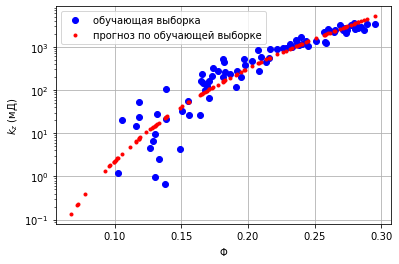

In [11]:
plt.semilogy(porosity, permeabilityZ, 'bo', label="обучающая выборка")
plt.semilogy(porosity, simplePrediction_permeabilityZ, '.r', label="прогноз по обучающей выборке")
plt.legend()
plt.grid()
plt.xlabel('$\Phi$')
plt.ylabel('$k_z$ (мД)')
plt.show()

Рассчитаем среднюю относительную ошибку прогноза по обучающей выборке по формуле $\epsilon_\mathit{rel}=\frac{1}{N}\sum_i^N\left|\frac{k_z^\mathit{true}-k_z^\mathit{model}}{k_z^\mathit{true}}\right|$.
Чтобы избежать деления на ноль, возьмем только те образцы, проницаемость которых больше маленького значения, например больше 0.001 мД:

In [12]:
relError=np.mean(abs(permeabilityZ[permeabilityZ>1e-3]-simplePrediction_permeabilityZ[permeabilityZ>1e-3])/permeabilityZ[permeabilityZ>1e-3])
print('Средняя относительная ошибка прогноза по обучающей выборке:', relError)


Средняя относительная ошибка прогноза по обучающей выборке: 1.137738491395304


В заключение проанализируем результаты прогноза. Последний график показывает, что регрессионная модель $k_z=c\Phi^m$ неплохо работает для проницаемости больше 100 мД, но при меньшей проницаемости данная модель не достоверна, что в итоге приводит к средней относительной ошибке прогноза более 1.

## Задача

Участникам хакатона предлагается разработать более совершенную методику прогноза проницаемости методами машинного обучения, используя общую пористость и профиль пористости образцов. Причем профиль пористости можно использовать как напрямую, так и косвенно, рассчитав статистику профиля (среднеквадратичное отклонение, максимальное/минимальное значение, симметрия и т. д.).

Решение нужно будет записать в эту тетрадку. Также нужно будет создать файл prediction_permeabilityZ.csv, содержащий ваши результаты прогноза проницаемости по тестовой выборке. 

## Загрузка тестовой выборки

In [13]:
test_porosity=np.genfromtxt('test_porosity.csv',invalid_raise=False,comments='#',delimiter=',')
print('Количество образцов в тестовой выборке: ',np.size(test_porosity))
test_porosityProfile=np.genfromtxt('test_porosityProfile.csv',invalid_raise=False,comments='#',delimiter=',')

Количество образцов в тестовой выборке:  100


Визуализация тестовой выборки:

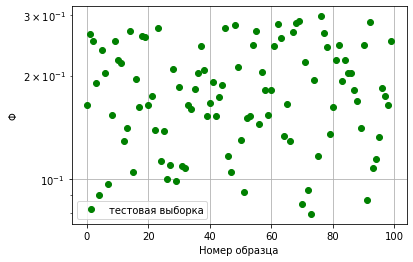

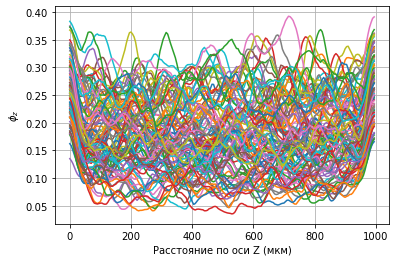

In [14]:
plt.semilogy(test_porosity,'go', label="тестовая выборка")
plt.legend()
plt.grid()
plt.ylabel('$\Phi$')
plt.xlabel('Номер образца')
plt.show()

test_Z = np.arange(len(test_porosityProfile[0,:])) * 5 # (мкм)
for i in np.arange(len(test_porosityProfile[:,0])):
    plt.plot(Z,test_porosityProfile[i,:])
plt.grid()
plt.xlabel('Расстояние по оси Z (мкм)')
plt.ylabel('$\phi_z$')
plt.show()

Для создания файла prediction_permeabilityZ.csv можно использовать функцию np.savetxt(), как это было сделано в секции "Простейшая зависимость проницаемости от общей пористости". Файл prediction_permeabilityZ.csv должен иметь тот же формат, что и файл simplePrediction_permeabilityZ.csv. Сначала идет заголовок 'абсолютная проницаемость вдоль оси Z (мД)', начинающийся с #. Далее проницаемость для всех образцов записывается в одну колонку так, чтобы строчки в файле prediction_permeabilityZ.csv соответствовали строчкам файла test_porosity.csv. 
Пример: значение проницаемости в пятой строчке файла prediction_permeabilityZ.csv соответствует пористости, записанной в пятой строчке файла test_porosity.csv.

Удачи!

# Для начала импортируем все необходимые библиотеки

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from tsfresh import extract_features,  select_features

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Сгенерируем новые признаки на основе имеющихся профилей пористости образцов.

Для этого необходимо привести их к специальному виду и воспользоваться встроенной функцией библиотеки sklearn

X_df - DataFrame с получившимися признаками и общей пористостью образцов

In [16]:
porosityProfile = pd.DataFrame(porosityProfile)
data_long = pd.DataFrame({0: porosityProfile.values.flatten(),
                          1: np.arange(porosityProfile.shape[0]).repeat(porosityProfile.shape[1])})

X = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings.EfficientFCParameters())

Feature Extraction: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


In [17]:
porosity1 = pd.DataFrame(porosity)
porosity1.columns = ['porosity']

y_train = permeabilityZ

X_df = pd.concat([X, porosity1], axis = 1)
X_df.shape

(100, 774)

Признаков получилось много, поэтому далее отберем 50 наиболее информативных

In [18]:
fs = SelectKBest(score_func=f_regression, k=50)
fs.fit(X_df, y_train)

X_train_fs = fs.transform(X_df)

Обучим модель DecisionTreeRegressor со стандартной настройкой параметров на новом наборе признаков

In [19]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_fs, y_train)

pred = dtr.predict(X_train_fs)
test = y_train

relError=np.mean(abs(test[test>1e-3]-pred[test>1e-3])/test[test>1e-3])
print('Средняя относительная ошибка прогноза по обучающей выборке:', relError)

Средняя относительная ошибка прогноза по обучающей выборке: 0.0


Такая низкая ошибка означает, что модель полноостью подстроилась под тестовый набор данных (переобучилась). Для борьбы с переобучением можно настроить параметры этого алгоритма с органичениемб например, на глубину дерева или же использовать DecisionTreeRegressor - модель, которая основана на решающих деревьях и будет строить окончательный результат на большом количестве дерервьев. В этой задаче будет использовано 40 деревьев 

In [20]:
rfr = RandomForestRegressor(n_estimators=40)
rfr.fit(X_train_fs, y_train)

pred = rfr.predict(X_train_fs)
test = y_train

relError=np.mean(abs(test[test>1e-3]-pred[test>1e-3])/test[test>1e-3])
print('Средняя относительная ошибка прогноза по обучающей выборке:', relError)

Средняя относительная ошибка прогноза по обучающей выборке: 0.3439383044425389


In [21]:
test_porosityProfile = pd.DataFrame(test_porosityProfile)
data_long = pd.DataFrame({0: test_porosityProfile.values.flatten(),
                          1: np.arange(test_porosityProfile.shape[0]).repeat(test_porosityProfile.shape[1])})

In [22]:
data_long

,0,1
0,0.252725,0
1,0.249475,0
2,0.243400,0
3,0.234150,0
4,0.223000,0
...,...,...
19995,0.275250,99
19996,0.289650,99
19997,0.300100,99
19998,0.308300,99


Перейдем непосредственно к прогнозу. Сначала нужно провести генерацию и отбор признаков, как это было сделано выше, а затем построить прогноз на полученных данных

In [21]:

X_df_test = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings.EfficientFCParameters())

Feature Extraction: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


In [22]:
test_porosity_df = pd.DataFrame(test_porosity)
test_porosity_df.columns = ['porosity']

X_df_ = pd.concat([X_df_test, test_porosity_df], axis = 1)
X_test_fs = fs.transform(X_df_)

In [23]:
Prediction_permeabilityZ = rfr.predict(X_test_fs)
np.savetxt('Prediction_permeabilityZ.csv', Prediction_permeabilityZ, 
           header='абсолютная проницаемость вдоль оси Z (мД)',delimiter=",")